In [180]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
from datetime import datetime
from dateutil.parser import parse
import os
import warnings
# warnings.filterwarnings('ignore')
# plt.style.use('seaborn-poster')
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pickle
from scipy.stats import norm
from distfit import distfit

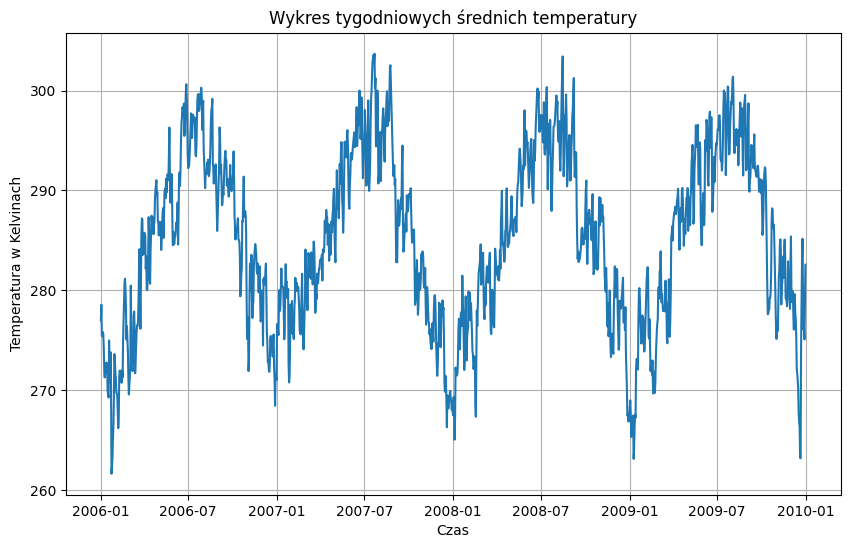

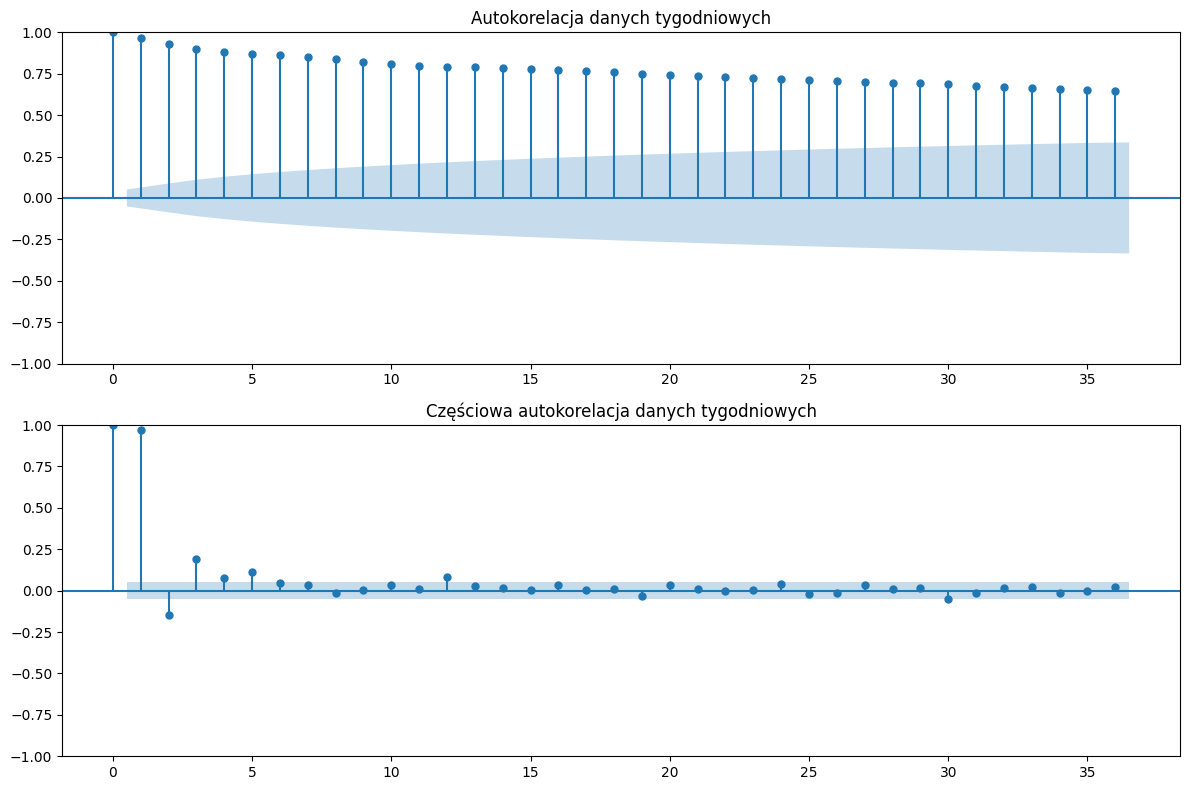

In [94]:
df = pd.read_csv('weatherHistory.csv')
#df.head()

# Zmiana nazw kolumn
df = df.rename(columns={'Temperature (C)': 'Temperature'})
df = df.rename(columns={'Formatted Date': 'Date'})

# Dodanie kolumny z temperaturą w Kelvinach
df['Temperature_K'] = df['Temperature'] + 273.15

# Konwertowanie daty
df['Date'] = df['Date'].astype(str)
df['Date'] = df['Date'].apply(lambda x: x.split('+')[0].strip())
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S.%f')

# Sortowanie
df = df.sort_values(by='Date')

# Wybór danych z lat 2006/09
df = df[(df['Date'].dt.year >= 2006) & (df['Date'].dt.year <= 2009)]

# Dane co 6h
#df = df.iloc[::6]
df_reduced = df[['Date', 'Temperature', 'Temperature_K']]
df = df_reduced.resample('D', on='Date').mean()

# Podstawowy wykres temperatury
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Temperature_K'])
plt.title("Wykres tygodniowych średnich temperatury")
plt.xlabel('Czas')
plt.ylabel('Temperatura w Kelvinach')
plt.grid(True)
plt.show()

# Badanie autokorelacji danych
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(df['Temperature_K'], lags=36, ax=ax1)
ax1.set_title("Autokorelacja danych tygodniowych")

sm.graphics.tsa.plot_pacf(df['Temperature_K'], lags=36, ax=ax2)
ax2.set_title("Częściowa autokorelacja danych tygodniowych")

plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.054103


<Figure size 800x600 with 0 Axes>

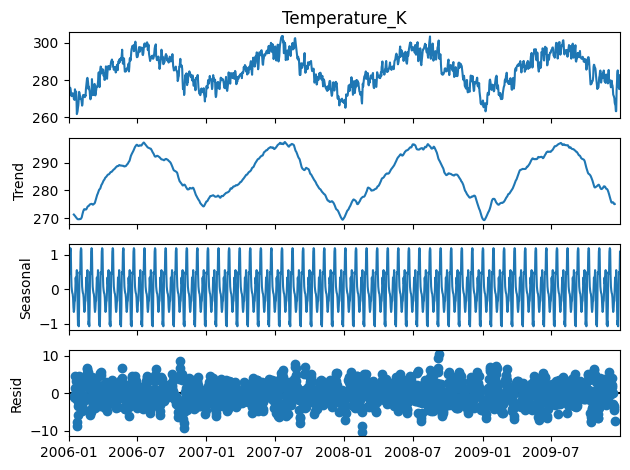

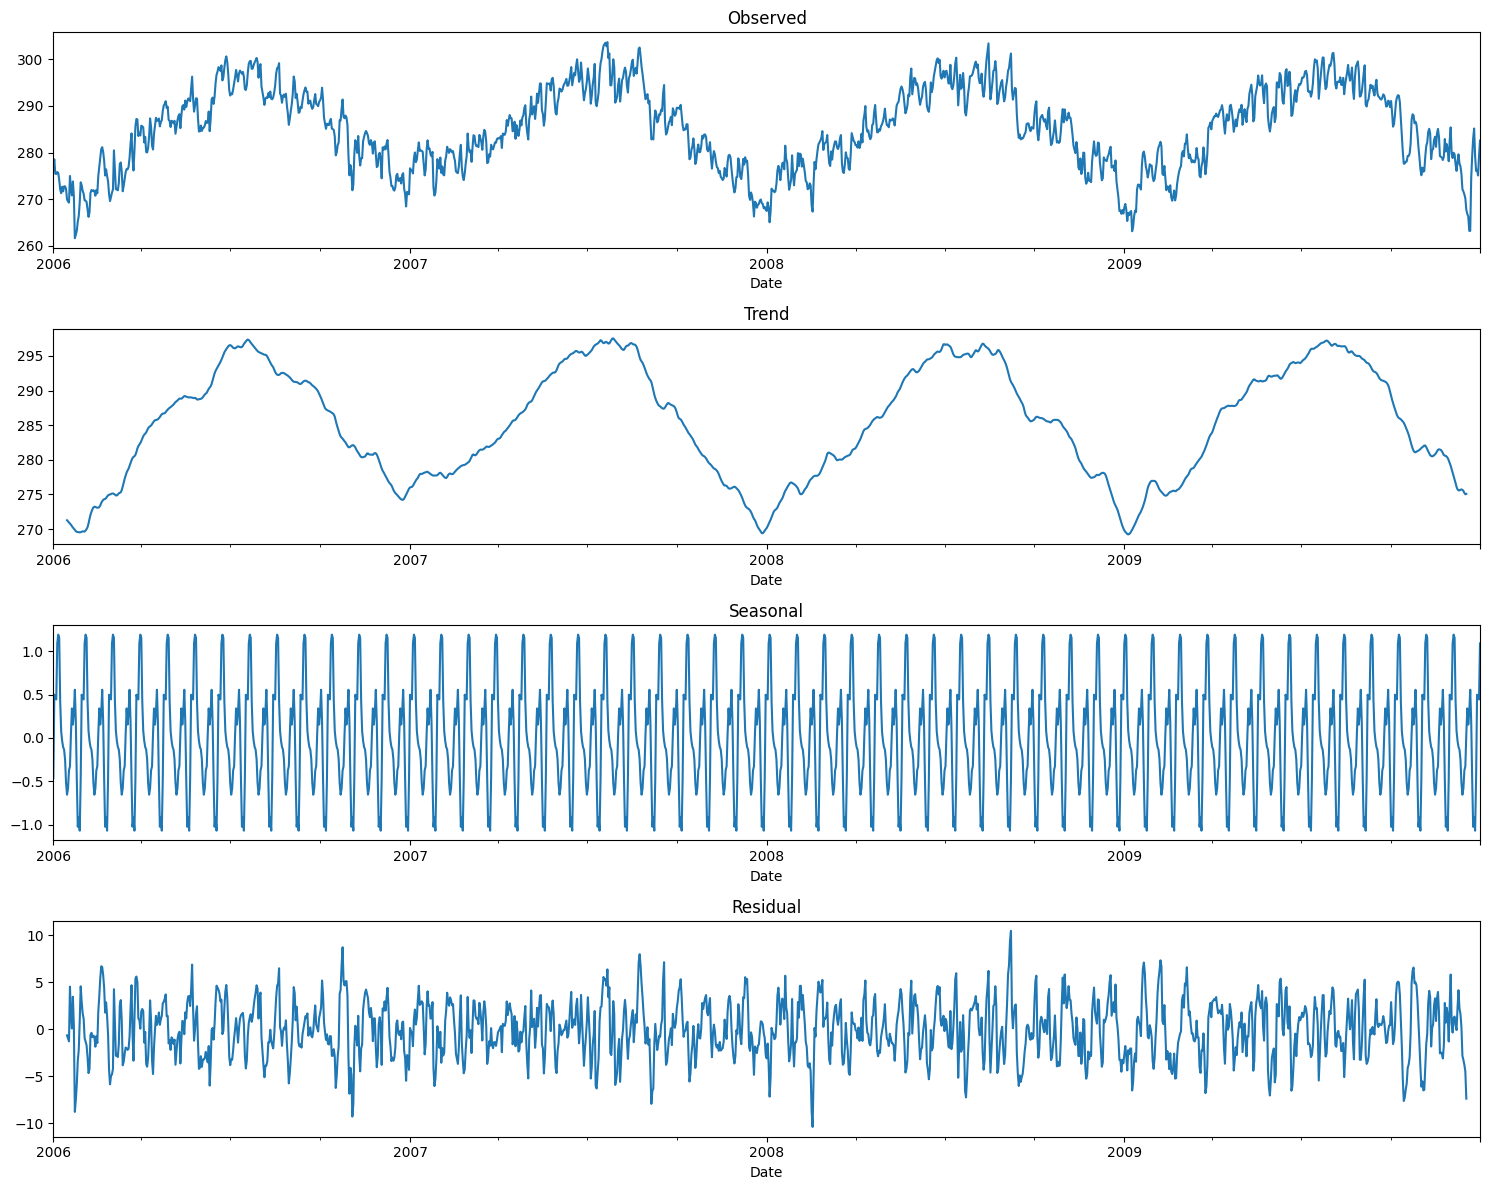

In [3]:
# Indeksowanie po dacie do sm.tsa
# df_copy = df[['Date', 'Temperature_K']].copy()
# df_copy = df_copy.set_index('Date')
df_copy = df[['Temperature_K']].copy()

# Dekompozycja Walda + test na stacjonarność szeregu
plt.figure(figsize=[8,6])
sm.tsa.seasonal_decompose(df_copy.Temperature_K, period=4*7).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_copy.Temperature_K)[1])
plt.show()

# Drugi sposób (wieksze wykresy)
decomposition = sm.tsa.seasonal_decompose(df_copy, model='additive', period=4*7) #1460//6
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

Lambda z transformacji BoxaCoxa: 1.3582745563352163


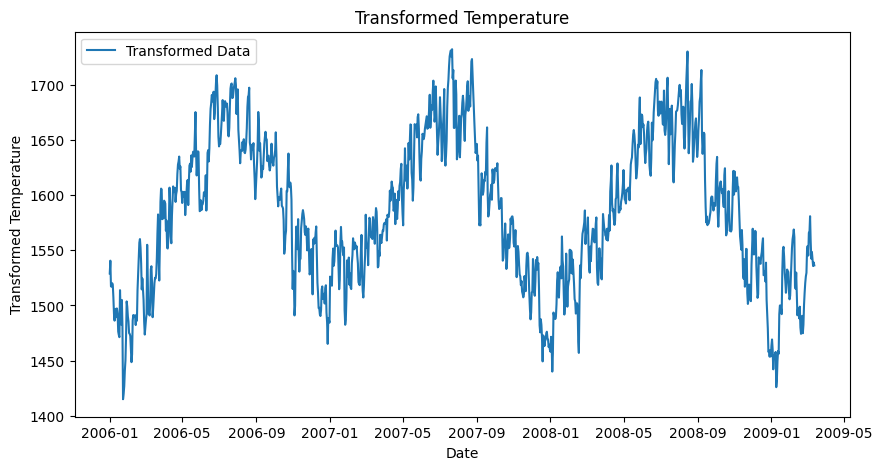

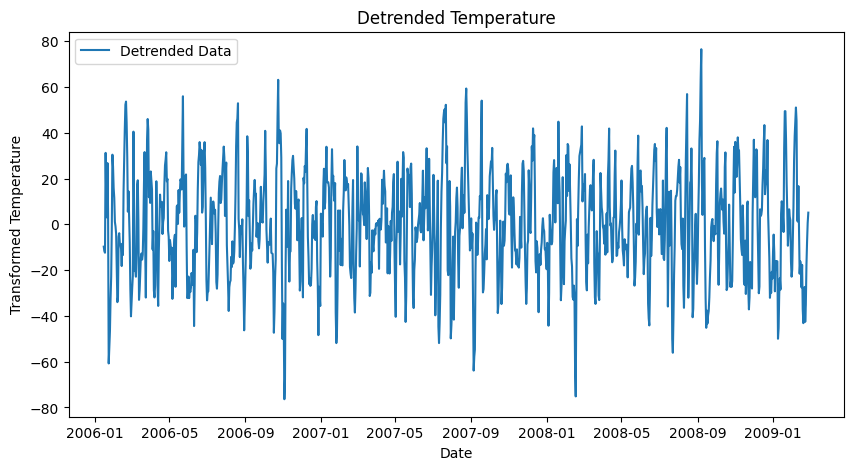

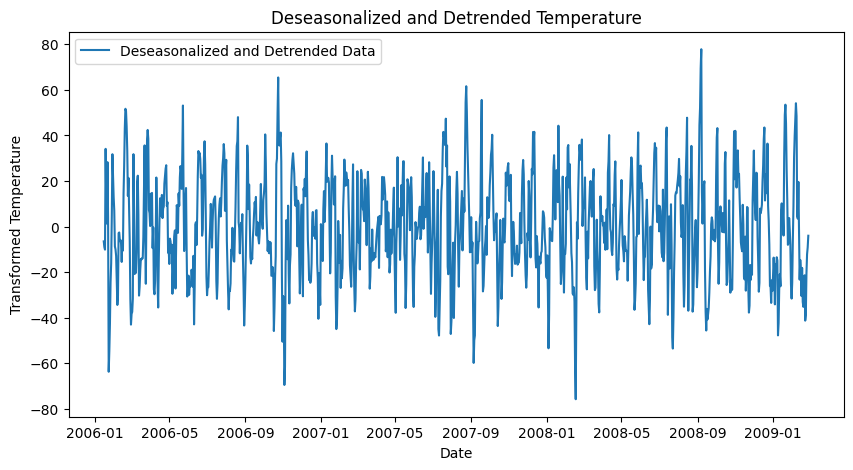

Dickey–Fuller test: p=0.000000


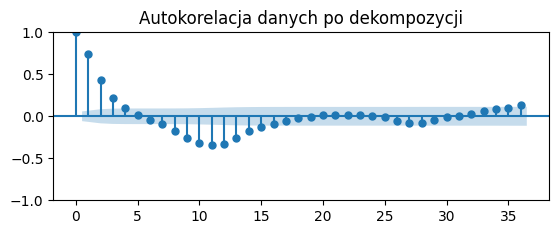

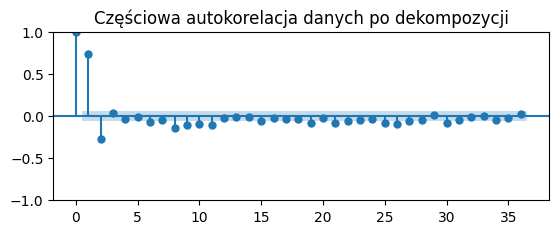

In [95]:
# Podział na train i test
train_size = int(len(df_copy) * 0.8)
train, test = df_copy[:train_size], df_copy[train_size:]

# Transformacja Boxa-Coxa
train_transformed, lmbda = stats.boxcox(train.Temperature_K)
print(f"Lambda z transformacji BoxaCoxa: {lmbda}")

# Dekompozycja danych na trend, sezonowość i resztę
decomposition = sm.tsa.seasonal_decompose(train_transformed, model='additive', period=28)

# Usunięcie trendu i sezonowości
detrended = train_transformed - decomposition.trend
deseasonalized = detrended - decomposition.seasonal

# Wykres po transformacji
plt.figure(figsize=(10, 5))
plt.plot(train.index, train_transformed, label='Transformed Data')
plt.xlabel("Date")
plt.ylabel("Transformed Temperature")
plt.title("Transformed Temperature")
plt.legend()
plt.show()

# Wykres po usunięciu trendu
plt.figure(figsize=(10, 5))
plt.plot(train.index, detrended, label='Detrended Data')
plt.xlabel("Date")
plt.ylabel("Transformed Temperature")
plt.title("Detrended Temperature")
plt.legend()
plt.show()

# Wykres detrendowanych i deseasonalizowanych danych
plt.figure(figsize=(10, 5))
plt.plot(train.index, deseasonalized, label='Deseasonalized and Detrended Data')
plt.xlabel("Date")
plt.ylabel("Transformed Temperature")
plt.title("Deseasonalized and Detrended Temperature")
plt.legend()
plt.show()

# Usunięcie wartości NaN i stworzenie nowego DataFrame
deseasonalized_series = pd.Series(deseasonalized, index=train.index)
deseasonalized_series.dropna(inplace=True)
deseasonalized_df = pd.DataFrame({'Transformed_T': deseasonalized_series})

# Test stacjonarności po dekompozycji Walda
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(deseasonalized_df.Transformed_T)[1])

# Badanie autokorelacji danych po dekompozycji
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(deseasonalized_df.Transformed_T.values.squeeze(), lags=36, ax=ax)
plt.title("Autokorelacja danych po dekompozycji")
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(deseasonalized_df.Transformed_T.values.squeeze(), lags=36, ax=ax)
plt.title("Częściowa autokorelacja danych po dekompozycji")
plt.show()

In [6]:
# Dopasowywanie najlepszych parametrów p, q
def test_model(data):
    qs = range(0, 5)
    ps = range(0, 5)
    d = 0

    parameters = product(ps, qs)
    parameters_list = list(parameters)

    # Model Selection
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    for param in parameters_list:
        try:
            model = ARIMA(data, order=(param[0], d, param[1])).fit()
        except ValueError:
            #print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    return results, best_model

In [7]:
results, best_model = test_model(deseasonalized_df.Transformed_T)

# Best Model
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

# Zapisywanie modelu
with open('best_model.pkl', 'wb') as pkl_file:
    pickle.dump(best_model, pkl_file)

# Wczytywanie modelu
with open('best_model.pkl', 'rb') as pkl_file:
    loaded_model = pickle.load(pkl_file)

   parameters          aic
12     (2, 2)  9228.326682
24     (4, 4)  9230.027402
19     (3, 4)  9230.717489
23     (4, 3)  9231.915067
18     (3, 3)  9232.278929
                               SARIMAX Results                                
Dep. Variable:          Transformed_T   No. Observations:                 1140
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -4608.163
Date:                Sat, 22 Jun 2024   AIC                           9228.327
Time:                        18:58:01   BIC                           9258.559
Sample:                    01-15-2006   HQIC                          9239.744
                         - 02-27-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0164      0.026      0.624     

MSE: 12.96
MAE: 2.93


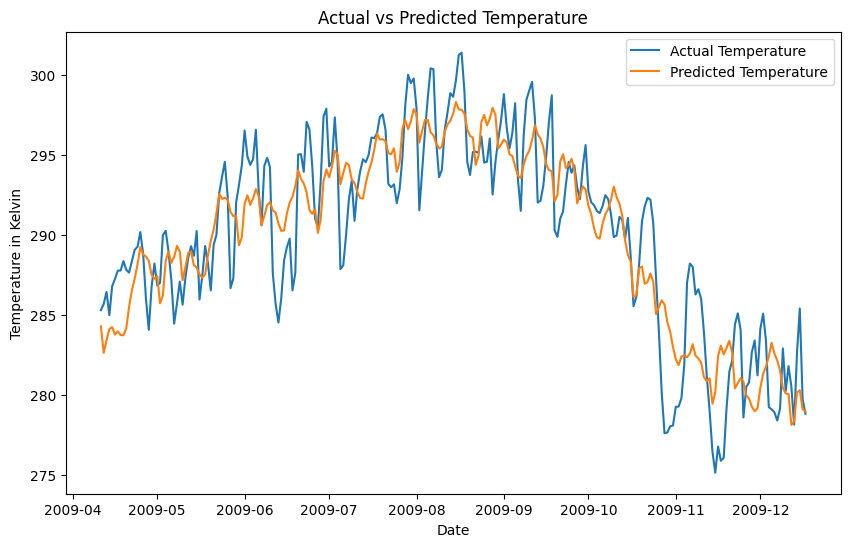

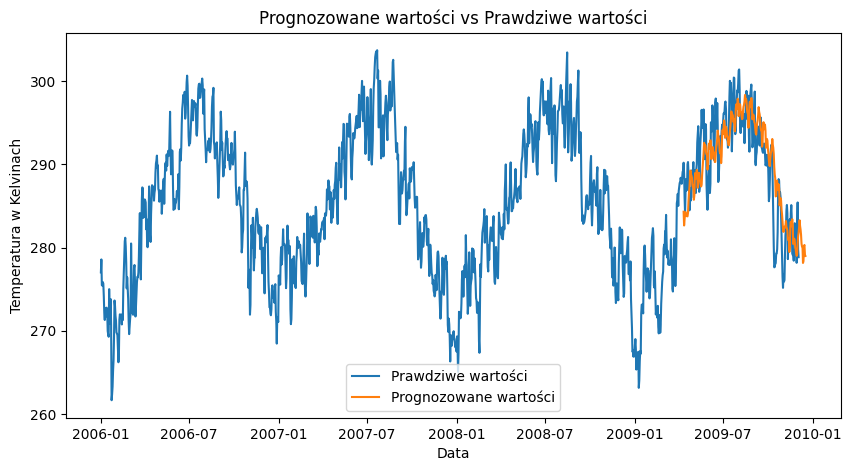

In [186]:
# Transformacja danych test za pomocą lamby z train
test_transformed = stats.boxcox(test.Temperature_K, lmbda=lmbda)

# Dekompozycja testowych
decomposition_test = sm.tsa.seasonal_decompose(test_transformed, model='additive', period=28)
detrended_test = test_transformed - decomposition_test.trend
deseasonalized_test = detrended_test - decomposition_test.seasonal
deseasonalized_test_series = pd.Series(deseasonalized_test, index=test.index)
deseasonalized_test_series.dropna(inplace=True)

# Predykcje
predicted_values = loaded_model.forecast(steps=len(deseasonalized_test_series))

# Dodanie trendu i sezonowości
predicted_values_recomposed = predicted_values + decomposition_test.trend[:len(predicted_values)] + decomposition_test.seasonal[:len(predicted_values)]

# Cofnięcie transformacji
def invboxcox(y, lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
predicted_values_original_scale = invboxcox(predicted_values_recomposed, lmbda)

# Obliczenie MSE
mse = np.mean((test.Temperature_K[14:265] - predicted_values_original_scale[14:])**2)
print(f"MSE: {mse:.2f}")

# Obliczenie MAE
mae = np.mean(np.abs(test.Temperature_K[14:265] - predicted_values_original_scale[14:]))
print(f"MAE: {mae:.2f}")

# Wykres dla danych test
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_test_series.index[14:], test.Temperature_K[14:265], label='Actual Temperature')
plt.plot(deseasonalized_test_series.index[14:], predicted_values_original_scale[14:], label='Predicted Temperature')
plt.title("Actual vs Predicted Temperature")
plt.xlabel('Date')
plt.ylabel('Temperature in Kelvin')
plt.legend()
plt.show()

# Wykres prognozowanych wartości dla całego df
plt.figure(figsize=(10, 5))
plt.plot(df.index[:-28], df.Temperature_K[:-28], label='Prawdziwe wartości')
plt.plot(deseasonalized_test_series.index, predicted_values_original_scale, label='Prognozowane wartości')
plt.xlabel("Data")
plt.ylabel("Temperatura w Kelvinach")
plt.title("Prognozowane wartości vs Prawdziwe wartości")
plt.legend()
plt.show()

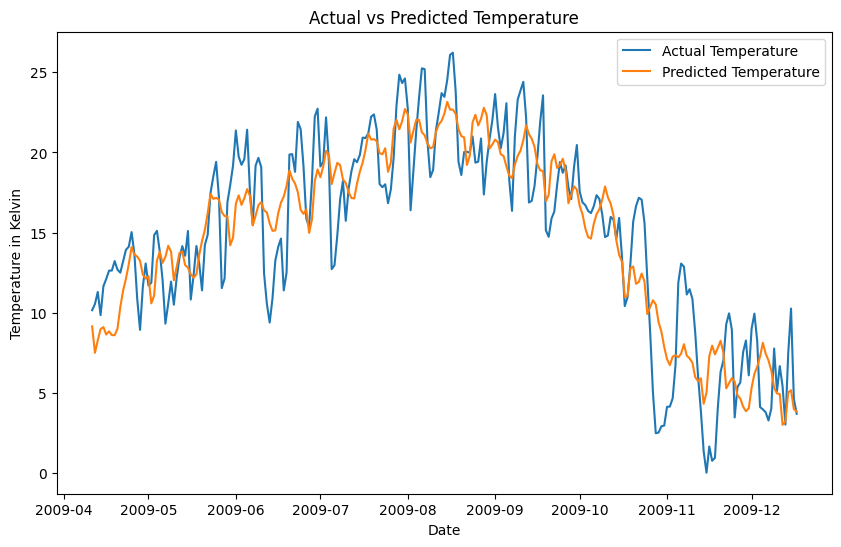

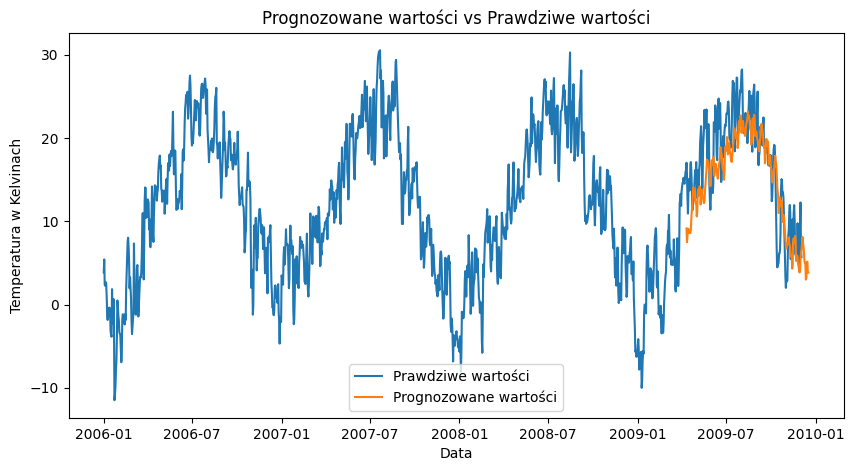

In [196]:
# Dla stopni
test['Temperature_C'] = test['Temperature_K'] - 275.15
predicted_values_original_scale_C = predicted_values_original_scale - 275.15

plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_test_series.index[14:], test.Temperature_C[14:265], label='Actual Temperature')
plt.plot(deseasonalized_test_series.index[14:], predicted_values_original_scale_C[14:], label='Predicted Temperature')
plt.title("Actual vs Predicted Temperature")
plt.xlabel('Date')
plt.ylabel('Temperature in Kelvin')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df.index[:-28], df.Temperature[:-28], label='Prawdziwe wartości')
plt.plot(deseasonalized_test_series.index, predicted_values_original_scale_C, label='Prognozowane wartości')
plt.xlabel("Data")
plt.ylabel("Temperatura w Kelvinach")
plt.title("Prognozowane wartości vs Prawdziwe wartości")
plt.legend()
plt.show()

-0.006719767085389549


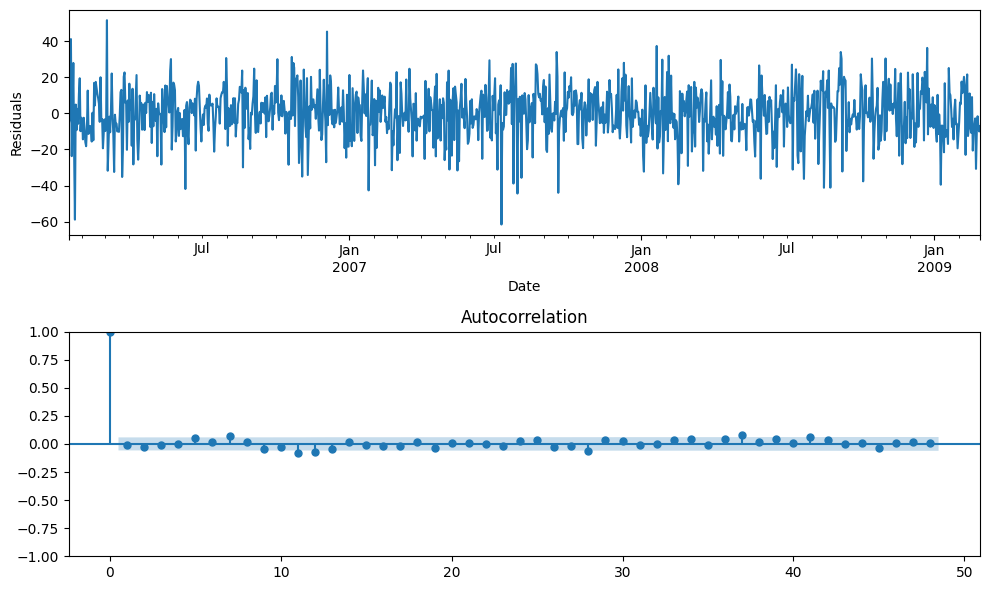

In [151]:
# Sprawdzanie założeń dotyczacych residuuów modelu
plt.figure(figsize=(10,6))
plt.subplot(211)
loaded_model.resid.plot()
plt.ylabel(u'Residuals')

mu = np.mean(best_model.resid)
print(mu)

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(loaded_model.resid.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

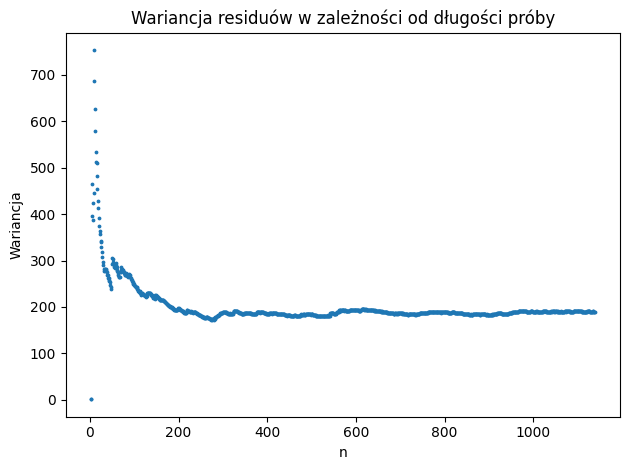

In [154]:
# Sprawdzenie stałości wariancji
e = loaded_model.resid
t232 = [i for i in range(2, len(e))]
war = [np.var(e[:i]) for i in range(2, len(e))]
plt.title("Wariancja residuów w zależności od długości próby")
plt.ylabel("Wariancja")
plt.xlabel("n")
plt.scatter(t232, war, s=3)

plt.tight_layout()
plt.show()

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.000217996] [loc=-0.007 scale=13.784]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.00781845] [loc=-61.586 scale=61.580]
[distfit] >[pareto    ] [0.00 sec] [RSS: 0.00781845] [loc=-8589934653.586 scale=8589934592.000]
[distfit] >[dweibull  ] [0.03 sec] [RSS: 0.000151537] [loc=0.013 scale=11.157]
[distfit] >[t         ] [0.09 sec] [RSS: 0.000127495] [loc=0.288 scale=12.118]
[distfit] >[genextreme] [0.08 sec] [RSS: 0.000420969] [loc=-5.211 scale=14.396]
[distfit] >[gamma     ] [0.04 sec] [RSS: 0.000268698] [loc=-252.562 scale=0.772]
[distfit] >[lognorm   ] [0.04 sec] [RSS: 0.0175618] [loc=-61.586 scale=1.567]
[distfit] >[beta      ] [0.09 sec] [RSS: 0.000196762] [loc=-3215.166 scale=3347.846]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.00583574] [loc=-61.586 scale=113.188]
[distfit] >[loggamma  ] [0.01 sec] [RSS: 0.000192455] [loc=-173.687 scale=59.388]
[distfit] >Compute confidence interval [parametric]


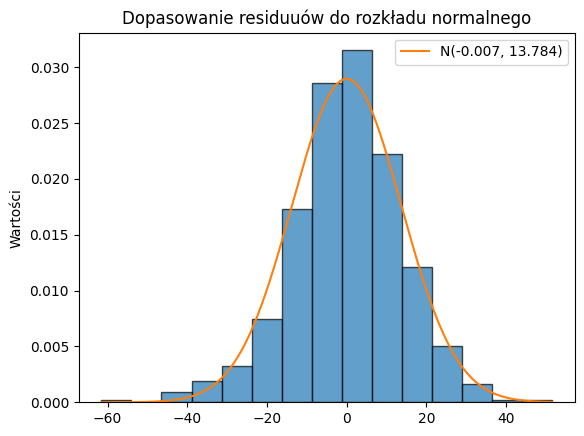

In [181]:
# Dopasowanie residuuów do rozkładu normalnego
dist = distfit()
model = dist.fit_transform(best_model.resid)
#dist.plot()

plt.hist(loaded_model.resid, bins=15, alpha=0.7, edgecolor='k', density=True)
t = np.linspace(min(loaded_model.resid), max(loaded_model.resid), 1000)
plt.plot(t, norm.pdf(t, loc=-0.007, scale=13.784), label="N(-0.007, 13.784)")

plt.ylabel("Wartości")
plt.title("Dopasowanie residuuów do rozkładu normalnego")
plt.legend()
plt.show()